<a href="https://colab.research.google.com/github/Devanshu0502/Sales-Prediction/blob/main/Sales_prediction_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRFRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/Projects/Big Mart Sales Prediction/Train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Projects/Big Mart Sales Prediction/Test.csv')

In [4]:
#Combine test and train into one file
train_df['source']='train'
test_df['source']='test'
df = pd.concat([train_df, test_df],ignore_index=True)
print(train_df.shape, test_df.shape, df.shape)

(8523, 13) (5681, 12) (14204, 13)


In [5]:
df.tail()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
14199,FDB58,10.5,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1,NaN,test
14200,FDD47,7.6,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2,NaN,test
14201,NCO17,10.0,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1,NaN,test
14202,FDJ26,15.3,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1,NaN,test
14203,FDU37,9.5,Regular,0.104720,Canned,79.7960,OUT045,2002,NaN,Tier 2,Supermarket Type1,NaN,test


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  source                     14204 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usag

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,11765.0,12.792854,4.652502,4.555,8.710000,12.600000,16.750000,21.350000
Item_Visibility,14204.0,0.065953,0.051459,0.000,0.027036,0.054021,0.094037,0.328391
Item_MRP,14204.0,141.004977,62.086938,31.290,94.012000,142.247000,185.855600,266.888400
Outlet_Establishment_Year,14204.0,1997.830681,8.371664,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


In [8]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [9]:
cat_col = list(df.select_dtypes('object').columns)
cat_col = [x for x in cat_col if x not in ['Item_Identifier','Outlet_Identifier','source']]

for col in cat_col:
    print(col, ' :')
    print(df[col].value_counts(), end='\n\n')

Item_Fat_Content  :
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Item_Type  :
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Outlet_Size  :
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

Outlet_Location_Type  :
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Outlet_Type  :
Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Ty

In [10]:
# Mean of item weight
df.Item_Weight.mean()

12.792854228644284

In [11]:
# Mean of item weight based on their item type
item_avg_weight = df.pivot_table(values='Item_Weight', columns='Item_Identifier')
item_avg_weight

Item_Identifier,DRA12,DRA24,DRA59,DRB01,DRB13,DRB24,DRB25,DRB48,DRC01,DRC12,...,NCZ05,NCZ06,NCZ17,NCZ18,NCZ29,NCZ30,NCZ41,NCZ42,NCZ53,NCZ54
Item_Weight,11.6,19.35,8.27,7.39,6.115,8.785,12.3,16.75,5.92,17.85,...,8.485,19.6,12.15,7.825,15.0,6.59,19.85,10.5,9.6,14.65


In [12]:
# Filling values to null weight
missing_values = df['Item_Weight'].isnull()

print('Missing Values: %d'% sum(missing_values))
df.loc[missing_values, 'Item_Weight'] = df.loc[missing_values, 'Item_Identifier'].apply(lambda x: item_avg_weight[x])
print('Missing Values after: %d'% sum(df['Item_Weight'].isnull()))

Missing Values: 2439
Missing Values after: 0


In [13]:
df["Outlet_Type"].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

In [14]:
df.groupby(["Outlet_Type"])["Outlet_Size"].value_counts()

Outlet_Type        Outlet_Size
Grocery Store      Small           880
Supermarket Type1  Small          3100
                   High           1553
                   Medium         1550
Supermarket Type2  Medium         1546
Supermarket Type3  Medium         1559
Name: Outlet_Size, dtype: int64

In [15]:
outlet_size_mode = df.pivot_table(values="Outlet_Size", columns="Outlet_Type", aggfunc=(lambda x: x.mode()))

In [16]:
outlet_size_mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [17]:
# Filling values to null outlet size
missing_values = df['Outlet_Size'].isnull()

print('Missing Values: %d'% sum(missing_values))
df.loc[missing_values, 'Outlet_Size'] = df.loc[missing_values, 'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print('Missing Values: %d'% sum(df['Outlet_Size'].isnull()))

Missing Values: 4016
Missing Values: 0


In [18]:
item_avg_visibility = df.pivot_table(values='Item_Visibility', columns='Item_Identifier')
item_avg_visibility

Item_Identifier,DRA12,DRA24,DRA59,DRB01,DRB13,DRB24,DRB25,DRB48,DRC01,DRC12,...,NCZ05,NCZ06,NCZ17,NCZ18,NCZ29,NCZ30,NCZ41,NCZ42,NCZ53,NCZ54
Item_Visibility,0.034938,0.045646,0.133384,0.079736,0.006799,0.020596,0.079407,0.023973,0.020653,0.037862,...,0.06303,0.102096,0.076568,0.180954,0.076774,0.027302,0.056396,0.011015,0.02633,0.081345


In [19]:
# Filling values to null outlet size
missing_values = (df['Item_Visibility'] == 0)

print('Number of zeros: %d'% sum(missing_values))
df.loc[missing_values, 'Item_Visibility'] = df.loc[missing_values, 'Item_Identifier'].apply(lambda x: item_avg_visibility[x])
print('Number of zero after: %d'% sum(df['Item_Visibility'] == 0))

Number of zeros: 879
Number of zero after: 0


In [20]:
df.Item_Visibility.describe()

count    14204.000000
mean         0.069710
std          0.049728
min          0.003575
25%          0.031145
50%          0.057194
75%          0.096930
max          0.328391
Name: Item_Visibility, dtype: float64

In [21]:
#Determine another variable with means ratio
df['Item_Visibility_MeanRatio'] = df.apply(lambda x: x['Item_Visibility']/item_avg_visibility[x['Item_Identifier']], axis=1)
df['Item_Visibility_MeanRatio'].describe()

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64

In [22]:
df['Item_type_combine'] = df['Item_Identifier'].apply(lambda x: x[0:2])
df['Item_type_combine'] = df['Item_type_combine'].map({'DR':'Drinks', 'FD':'Food', 'NC': 'Non-Consumable'})

df['Item_type_combine'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_type_combine, dtype: int64

In [23]:
df.pivot_table(values='Item_Visibility', columns='Item_type_combine')

Item_type_combine,Drinks,Food,Non-Consumable
Item_Visibility,0.068703,0.072042,0.061347


In [24]:
df['Outlet_Years'] = 2013 - df['Outlet_Establishment_Year']
df['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [25]:
df.replace({'Item_Fat_Content': {
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'
}}, inplace=True)

In [26]:
df.Item_Fat_Content.value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

In [27]:
df.loc[df['Item_type_combine'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
df['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [28]:
df.select_dtypes('object').columns

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'source',
       'Item_type_combine'],
      dtype='object')

In [29]:
outlet_sales = df.groupby('Outlet_Identifier')['Item_Outlet_Sales'].sum().sort_values(ascending=False)

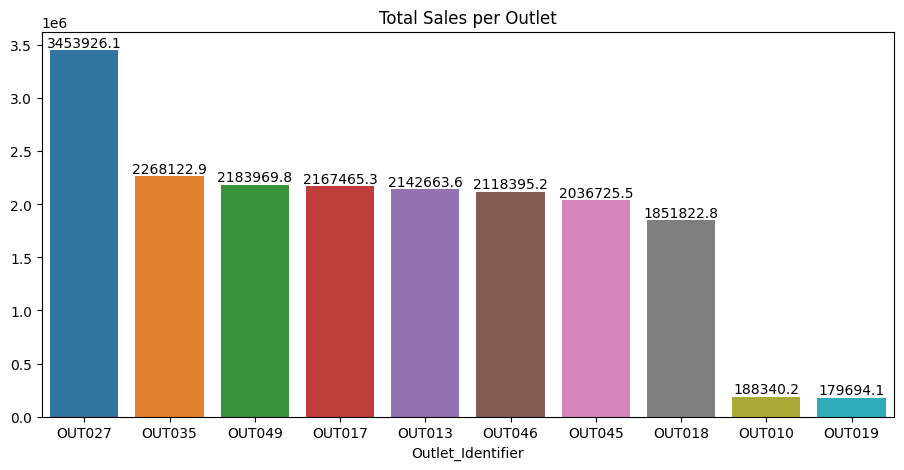

In [30]:
plt.figure(figsize=(11, 5))
ax = sns.barplot(x=outlet_sales.index, y=outlet_sales.values, order=outlet_sales.index)
ax.bar_label(ax.containers[0], fmt='%.1f')
plt.title('Total Sales per Outlet')
plt.show()

In [31]:
item_type_sales = df.groupby('Item_Type')['Item_Outlet_Sales'].sum()

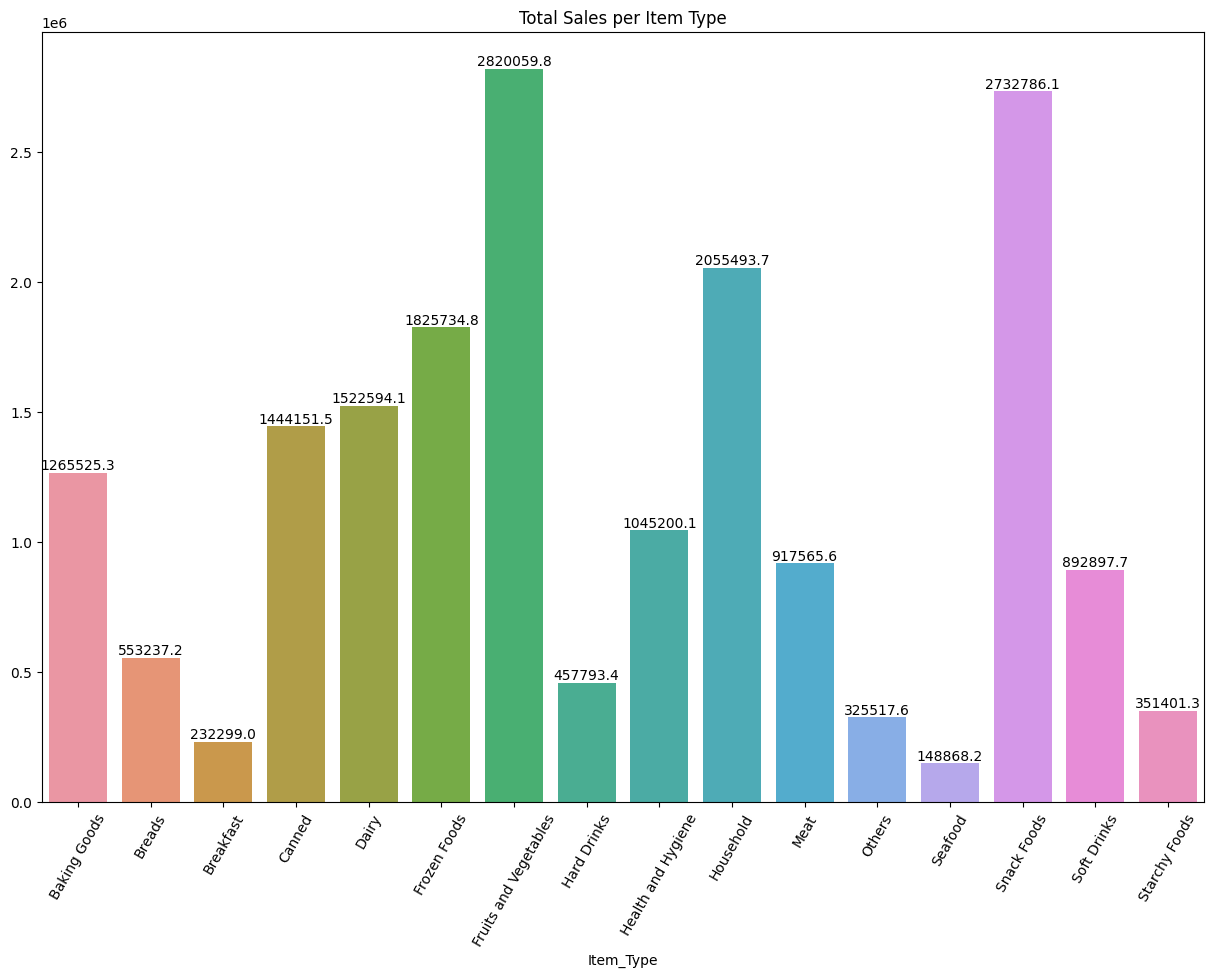

In [32]:
plt.figure(figsize=(15, 10))
ax = sns.barplot(x=item_type_sales.index, y=item_type_sales.values, order=item_type_sales.index)
ax.bar_label(ax.containers[0], fmt='%.1f')
plt.xticks(rotation=60)
plt.title('Total Sales per Item Type')
plt.show()

Text(0.5, 1.0, 'No of items sold since')

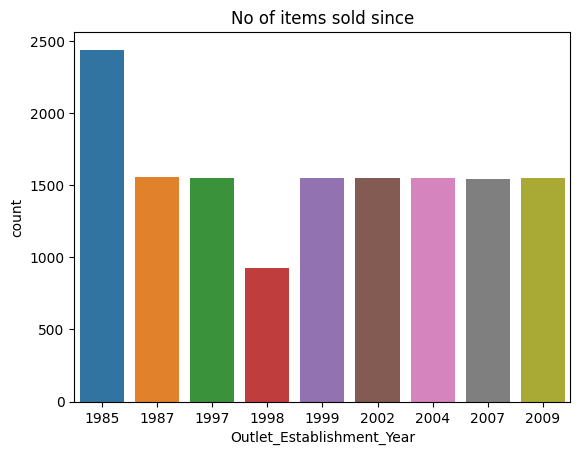

In [33]:
sns.countplot(x=df['Outlet_Establishment_Year'])
plt.title('No of items sold since')

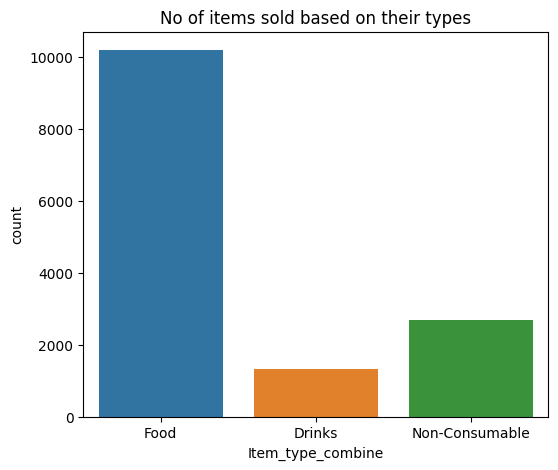

In [34]:
plt.figure(figsize=(6, 5))
sns.countplot(x=df['Item_type_combine'])
plt.title('No of items sold based on their types')
plt.show()

<Figure size 600x600 with 0 Axes>

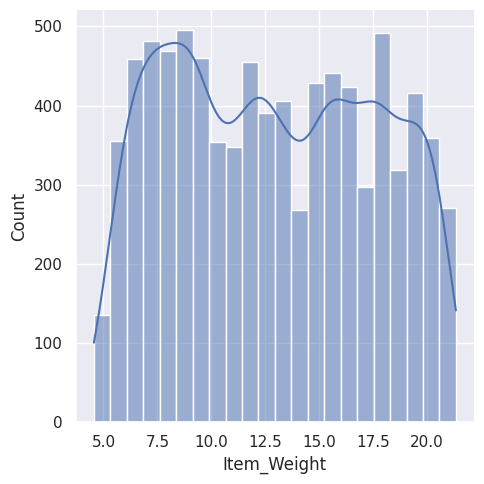

In [35]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(6,6))
sns.displot(df[df['source'] == 'train']['Item_Weight'], kde=True)
plt.show()

<Figure size 600x600 with 0 Axes>

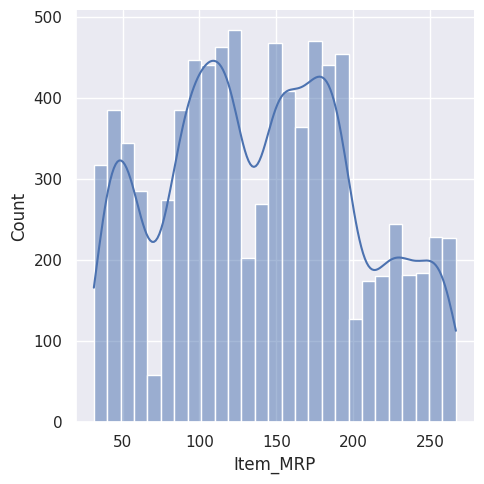

In [36]:
plt.figure(figsize=(6,6))
sns.displot(df[df['source'] == 'train']['Item_MRP'], kde=True)
plt.show()

<Figure size 600x600 with 0 Axes>

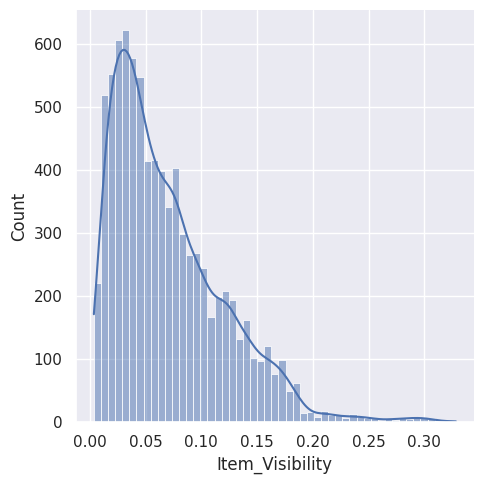

In [37]:
plt.figure(figsize=(6,6))
sns.displot(df[df['source'] == 'train']['Item_Visibility'], kde=True)
plt.show()

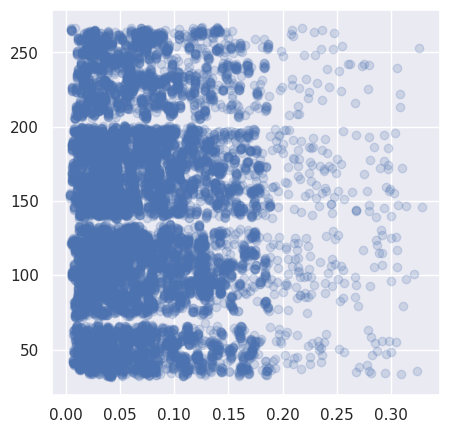

In [38]:
plt.figure(figsize=(5, 5))
plt.scatter(x=df['Item_Visibility'], y=df['Item_MRP'], alpha=0.2)

In [39]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

In [40]:
df['Outlet'] = encoder.fit_transform(df['Outlet_Identifier'])

In [41]:
cols = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_type_combine','Outlet_Type', 'Outlet']

for col in cols:
    df[col] = encoder.fit_transform(df[col])

In [42]:
df = pd.get_dummies(df, columns=cols, drop_first=True)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                14204 non-null  float64
 2   Item_Visibility            14204 non-null  float64
 3   Item_Type                  14204 non-null  object 
 4   Item_MRP                   14204 non-null  float64
 5   Outlet_Identifier          14204 non-null  object 
 6   Outlet_Establishment_Year  14204 non-null  int64  
 7   Item_Outlet_Sales          8523 non-null   float64
 8   source                     14204 non-null  object 
 9   Item_Visibility_MeanRatio  14204 non-null  float64
 10  Outlet_Years               14204 non-null  int64  
 11  Item_Fat_Content_1         14204 non-null  uint8  
 12  Item_Fat_Content_2         14204 non-null  uint8  
 13  Outlet_Location_Type_1     14204 non-null  uin

In [44]:
df['Outlet_Years'] = df['Outlet_Years'].astype('uint8')
df[["Item_Weight", "Item_Visibility", "Item_MRP"]] = df[["Item_Weight", "Item_Visibility", "Item_MRP"]].astype("float16")

In [45]:
df.memory_usage(index=False, deep=True).sum()

4345237

In [46]:
df.drop(['Item_Type','Outlet_Establishment_Year'], axis=1, inplace=True)

#Divide into test and train:
train = df.loc[df['source']=="train"]
test = df.loc[df['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

In [47]:
train.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Item_Outlet_Sales,Item_Visibility_MeanRatio,Outlet_Years,Item_Fat_Content_1,Item_Fat_Content_2,...,Outlet_Type_3,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,9.296875,0.016052,249.75000,OUT049,3735.1380,0.931078,14,0,0,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,5.921875,0.019272,48.28125,OUT018,443.4228,0.933420,4,0,1,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,17.500000,0.016754,141.62500,OUT049,2097.2700,0.960069,14,0,0,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,19.203125,0.017838,182.12500,OUT010,732.3800,1.000000,15,0,1,...,0,0,0,0,0,0,0,0,0,0
4,NCD19,8.929688,0.009781,53.87500,OUT013,994.7052,1.000000,26,1,0,...,0,1,0,0,0,0,0,0,0,0


In [48]:
train.shape

(8523, 28)

In [49]:
target = 'Item_Outlet_Sales'
identifiers = ['Item_Identifier', 'Outlet_Identifier']
predictors = [x for x in train.columns if x not in [target]+identifiers]

In [50]:
def modelfit(model, dtrain, dtest, predictors, target, IDcol):

    model.fit(dtrain[predictors], dtrain[target])
        
    dtrain_predictions = model.predict(dtrain[predictors])

    cv_score = cross_val_score(model, dtrain[predictors], dtrain[target], cv=10, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))


Model Report
RMSE : 1127
CV Score : Mean - 1130 | Std - 16.4 | Min - 1109 | Max - 1163


<Axes: title={'center': 'Model Coefficients'}>

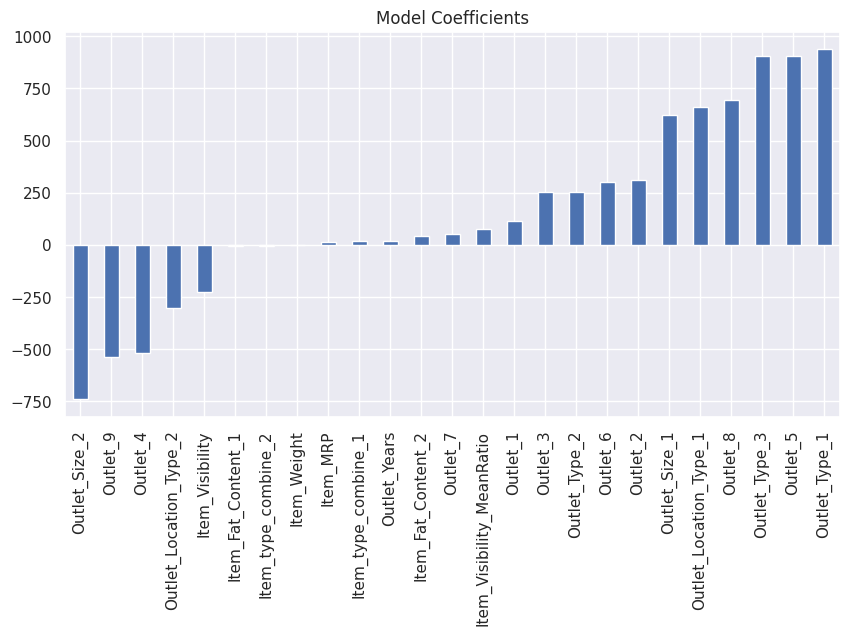

In [51]:
linreg = LinearRegression()
modelfit(linreg, train, test, predictors, target, identifiers)

coef1 = pd.Series(linreg.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients', figsize=(10,5))


Model Report
RMSE : 1127
CV Score : Mean - 1130 | Std - 16.4 | Min - 1109 | Max - 1163

Model Report
RMSE : 1128
CV Score : Mean - 1130 | Std - 16.36 | Min - 1109 | Max - 1163

Model Report
RMSE : 0
CV Score : Mean - 1549 | Std - 48.07 | Min - 1478 | Max - 1637

Model Report
RMSE : 1075
CV Score : Mean - 1108 | Std - 26.8 | Min - 1066 | Max - 1158


<Axes: title={'center': 'Model Coefficients'}>

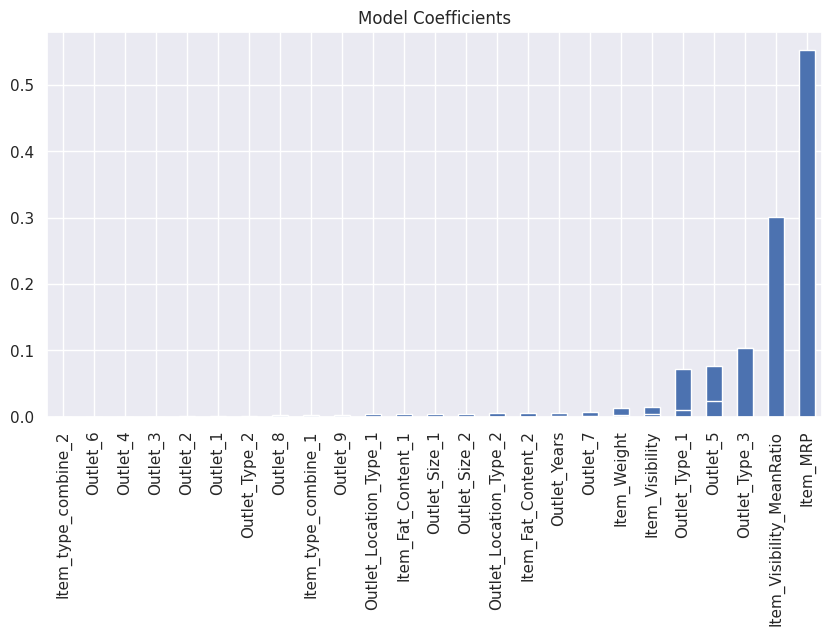

In [52]:
ridreg = Ridge(alpha=0.05)
modelfit(ridreg, train, test, predictors, target, identifiers)

lasreg = Lasso(alpha=1.0)
modelfit(lasreg, train, test, predictors, target, identifiers)

desreg = DecisionTreeRegressor()
modelfit(desreg, train, test, predictors, target, identifiers)

coef1 = pd.Series(desreg.feature_importances_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients', figsize=(10,5))


desreg1 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(desreg1, train, test, predictors, target, identifiers)

coef1 = pd.Series(desreg1.feature_importances_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients', figsize=(10,5))

In [53]:
param_grid = {
    'max_depth': [x for x in range(0,101, 5)],
    'min_samples_leaf': [1, 5, 10, 20, 50, 100, 150, 200],
}  

grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10)

In [54]:
grid.fit(train[predictors], train[target])

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
                                       55, 60, 65, 70, 75, 80, 85, 90, 95,
                                       100],
                         'min_samples_leaf': [1, 5, 10, 20, 50, 100, 150, 200]})

In [55]:
desreg2 = grid.best_estimator_
modelfit(desreg2, train, test, predictors, target, identifiers)


Model Report
RMSE : 1083
CV Score : Mean - 1099 | Std - 19.79 | Min - 1061 | Max - 1130


In [56]:
grid.best_params_

{'max_depth': 5, 'min_samples_leaf': 1}

In [57]:
randreg = RandomForestRegressor()
modelfit(randreg, train, test, predictors, target, identifiers)

randreg1 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(randreg1, train, test, predictors, target, identifiers)

randreg2 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
modelfit(randreg2, train, test, predictors, target, identifiers)


Model Report
RMSE : 422.2
CV Score : Mean - 1135 | Std - 26.17 | Min - 1090 | Max - 1185

Model Report
RMSE : 1092
CV Score : Mean - 1106 | Std - 28.51 | Min - 1059 | Max - 1150

Model Report
RMSE : 1086
CV Score : Mean - 1104 | Std - 28.05 | Min - 1059 | Max - 1149


In [58]:
param_grid = {
    'n_estimators': [400],
    'max_depth': [2, 4, 6, 8],
    #'min_samples_leaf': [],
    'n_jobs': [5]
}  

grid1 = GridSearchCV(RandomForestRegressor(), param_grid, cv=10)
grid1.fit(train[predictors], train[target])

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8], 'n_estimators': [400],
                         'n_jobs': [5]})

In [59]:
grid1.best_params_

{'max_depth': 8, 'n_estimators': 400, 'n_jobs': 5}

In [60]:
modelfit(grid1.best_estimator_, train, test, predictors, target, identifiers)


Model Report
RMSE : 1004
CV Score : Mean - 1089 | Std - 19.56 | Min - 1062 | Max - 1119


In [61]:
param_grid = {
    'n_estimators': [600],
    'max_depth': [2, 4, 6, 8],
    #'min_samples_leaf': [],
    'n_jobs': [5, 6]
}  

grid2 = GridSearchCV(RandomForestRegressor(), param_grid, cv=10)
grid2.fit(train[predictors], train[target])
grid2.best_params_

{'max_depth': 8, 'n_estimators': 600, 'n_jobs': 6}

In [62]:
modelfit(grid2.best_estimator_, train, test, predictors, target, identifiers)


Model Report
RMSE : 1004
CV Score : Mean - 1089 | Std - 19.6 | Min - 1063 | Max - 1122


In [63]:
modelfit(RandomForestRegressor(n_estimators=800, max_depth=8, n_jobs=5), train, test, predictors, target, identifiers)



Model Report
RMSE : 1004
CV Score : Mean - 1089 | Std - 19.72 | Min - 1060 | Max - 1121


In [64]:
alg1 = AdaBoostRegressor()
modelfit(alg1, train, test, predictors, target, identifiers)

alg2 = BaggingRegressor()
modelfit(alg2, train, test, predictors, target, identifiers)

alg3 = GradientBoostingRegressor()
modelfit(alg3, train, test, predictors, target, identifiers)


Model Report
RMSE : 1242
CV Score : Mean - 1237 | Std - 42.28 | Min - 1174 | Max - 1285

Model Report
RMSE : 483.4
CV Score : Mean - 1178 | Std - 22.15 | Min - 1144 | Max - 1210

Model Report
RMSE : 1037
CV Score : Mean - 1089 | Std - 17.87 | Min - 1067 | Max - 1124


In [65]:
gb=GradientBoostingRegressor(max_depth=7,n_estimators=200,learning_rate=0.01)
param=[{'min_samples_split':[5,9,13],'max_leaf_nodes':[3,5,7,9],'max_features':[8,10,15,18]}]
gs=GridSearchCV(gb,param,cv=5,scoring='neg_mean_squared_error')
gs.fit(train[predictors], train[target])
gs.best_params_

{'max_features': 18, 'max_leaf_nodes': 9, 'min_samples_split': 13}

In [66]:
modelfit(gs.best_estimator_, train, test, predictors, target, identifiers)


Model Report
RMSE : 1096
CV Score : Mean - 1109 | Std - 20.6 | Min - 1083 | Max - 1148


In [67]:
modelfit(GradientBoostingRegressor(n_estimators=200, max_leaf_nodes=8, max_depth=5, learning_rate=0.01), 
         train, test, predictors, target, identifiers)


Model Report
RMSE : 1103
CV Score : Mean - 1114 | Std - 22.66 | Min - 1085 | Max - 1156
